# Keras Autoencoder with Annoy for CBIR

## Black and White 32x64 pixels, 4x8x128 encoder convolutions, GlobalAverage to 128 dimensions

#### Results: Not good at all!  Much better results without black and white images. No processing seems better, even at small image sizes.

From Annoy:
Number of incorrect pills:       14 out of 24 pills
Number of incorrect pill images: 17 out of 96 images

In [1]:
import keras
keras.__version__

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


'2.2.2'

In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 17196854972103353113
]


In [3]:
import tensorflow as tf
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
sess.list_devices()

[_DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 268435456)]

In [4]:
from keras import backend as K
#K.tensorflow_backend._get_available_gpus()

# Train model

## Training variables

In [6]:

#target_image_size = (64,112)
target_image_size = (32,64)

color_mode='grayscale' # 'grayscale' or 'rgb'

if color_mode=='grayscale':
    target_image_size_3D = (target_image_size[0], target_image_size[1], 1)
else: #then rgb
    target_image_size_3D = (target_image_size[0], target_image_size[1], 3)

batch_size_training = 32
batch_size_validation = 32

# Directories
image_dir_training ='data_bw_with_rotations/train'
image_dir_validation = 'data_bw_with_rotations/validate'
image_dir_testing = 'data_bw_with_rotations/test'
image_dir_samples = image_dir_testing

# Training variables
training_steps_per_epoch = 200
training_number_of_epoch = 100
validation_steps = 100

# Model name to save
model_name='autoencoder_bw'

# Model name to load for Testing
model_name_pretrained = model_name

# Encoder model name
model_name_encoder = model_name + '-encoder'

In [7]:
# Testing variables

In [8]:
# Import required items for training
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, ZeroPadding2D, Dense, GlobalMaxPooling2D, GlobalAveragePooling2D
from keras.models import Model, load_model
from keras.callbacks import TensorBoard, EarlyStopping
from keras import callbacks
from keras.datasets import mnist
from keras.preprocessing.image import ImageDataGenerator
import numpy as np


from sklearn.metrics import label_ranking_average_precision_score
import time

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


## Convenience functions

In [9]:
# Unfortunately, matplotlib, cv2, etc only print in greyscale 
#   when you have 3 color axes (RGB) all set to make the image look grey.
#   But Keras loads greyscale images with only a single number (to optimize training, etc)
#   So, we need to convert any Keras greyscale images to have 3 values

def display_image(single_image):
    #check to see if image is rgb
    if (np.shape(single_image)[-1]==3):
        plt.imshow(single_image)
    if (np.shape(single_image)[-1]==1):
        si = np.concatenate((single_image,single_image,single_image), axis=2)
        plt.imshow(si)
        
def get_image(single_image):
    #check to see if image is rgb
    if (np.shape(single_image)[-1]==3):
        return single_image
    if (np.shape(single_image)[-1]==1):
        si = np.concatenate((single_image,single_image,single_image), axis=2)
        return si

def convertAllNonWhiteToBW(single_image):
    si = single_image
    si[si!=255]=0
    #si.setflags(write=1)
    return si

## ImageDataGenerators 

In [10]:
# Created the Train and Validation image generators

# Load the data (in that case MNIST)
train_datagen = ImageDataGenerator(
        #shear_range=0.05,
        #zoom_range=0.01,
        #rotation_range=5.00,
        #height_shift_range=0.10,
        #width_shift_range=0.10,
        rescale=1. / 255,
        horizontal_flip=False,
        preprocessing_function=convertAllNonWhiteToBW)

validation_datagen = ImageDataGenerator(rescale=1. / 255,
        preprocessing_function=convertAllNonWhiteToBW)

train_generator = train_datagen.flow_from_directory(
        image_dir_training,
        target_size=target_image_size,
        batch_size=batch_size_training,
        class_mode='input',
        color_mode=color_mode)

validation_generator = validation_datagen.flow_from_directory(
        image_dir_validation,
        target_size=target_image_size,
        batch_size=batch_size_validation,
        class_mode='input',
        color_mode=color_mode)



Found 722 images belonging to 1 classes.
Found 191 images belonging to 1 classes.


In [11]:
def convertAllNonWhiteToBW(single_image):
    si = single_image
    si[si!=255]=0
    #si.setflags(write=1)
    return si

Found 96 images belonging to 1 classes.


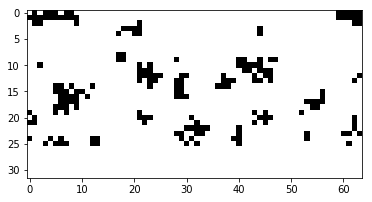

In [14]:
# Create an Sample image generator and get sample images to use throughout all the training for visualization


# Create callback function to use later.
sample_datagen = ImageDataGenerator(rescale=1. / 255,
        preprocessing_function=convertAllNonWhiteToBW)

sample_generator = sample_datagen.flow_from_directory(
        image_dir_samples,
        target_size=target_image_size,
        batch_size=16,
        class_mode='input',
        color_mode=color_mode)

next_batch = next(sample_generator)
sample_images = next_batch[0]
test_image=sample_images[1]
ti = test_image

#ti[ti!=1]=0

display_image(ti)




## Define Model for Training - Architecture

In [15]:
def define_model():
    
    
    #Input
    input_img = Input(shape=target_image_size_3D, name='input')  # adapt this if using `channels_first` image data format
    
     # Layer 10
    x = Conv2D(16, (3, 3), activation='relu', padding='same', strides=(1,1))(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    
    # Layer 20
    x = Conv2D(32, (3, 3), activation='relu', padding='same', strides=(1,1))(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    
#    # Added
#    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
#    x = MaxPooling2D((2, 2), padding='same')(x)
#    
#    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
#    x = MaxPooling2D((2, 2), padding='same')(x)

    # Layer 30

#    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
#    x = MaxPooling2D((2, 2), padding='same')(x)
    
    # Layer 40
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    encoded = MaxPooling2D((2, 2), padding='same', name='encoder')(x)

    # at this point the representation is (4, 4, 8) i.e. 128-dimensional

    # Uplayer 40
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(encoded)
    x = UpSampling2D((2, 2))(x)
    
    # Uplayer 30
#    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
#    x = UpSampling2D((2, 2))(x)


#    #Added
#    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
#    x = UpSampling2D((2, 2))(x)  
#    
#    x = Conv2D(32, (3, 3), activation='relu')(x)
#    #x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
#    x = UpSampling2D((2, 2))(x)  
    
    # Uplayer 20
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    
    # Uplayer 10
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    
    # Output
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same', name='decoded')(x)


    autoencoder = Model(input_img, outputs=decoded)
    autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

    print(autoencoder.outputs)
        
    return autoencoder
    

In [16]:
# Create callback to write sample images to disk
class ProgressCallback(callbacks.Callback):
    
    def __init__(self, sample_image):
        self.sample_image = sample_image
        self.image4d = self.sample_image[None,:] # predict needs a batch of images (shape=4). This adds a dimension  
        
    def on_epoch_end(self, epoch, logs={}):
        
        processed_images = self.model.predict(x=[self.image4d],batch_size=1)
         
        # plot the image and save it
        f = plt.figure()
        f.add_subplot(1, 2, 1)  # this line outputs images side-by-side
        sim = get_image(self.sample_image)
        plt.imshow(sim)
        f.add_subplot(1, 2, 2)  # this line outputs images side-by-side
        pim = get_image(processed_images[0])
        plt.imshow(pim)
        plt.suptitle('Epoch ' + str(epoch))
        filename = 'epoch-' + str(epoch) + '.png'
        plt.savefig(filename)
        plt.close()
        #plt.show()


In [17]:
# Train the model
def train_model(model_to_train):
    progress = ProgressCallback(sample_image=sample_images[0])
    early_stop = EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=4,
                              verbose=0, mode='auto')
    model_to_train.fit_generator(
        train_generator,
        steps_per_epoch=training_steps_per_epoch,
        epochs=training_number_of_epoch,
        validation_data=validation_generator,
        validation_steps=validation_steps,
        callbacks=[TensorBoard(log_dir='/tmp/tb', histogram_freq=0, write_graph=False),progress,early_stop])
    
    model_to_train.save(model_name + '.h5')
    
    return model_to_train

In [18]:
#autoencoder.save('autoencoder_8by14by128.h5')

In [19]:
# Train the model
x = define_model()

[<tf.Tensor 'decoded/Sigmoid:0' shape=(?, 32, 64, 1) dtype=float32>]


In [20]:
print(x.summary())


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 32, 64, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 64, 16)        160       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 32, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 32, 32)        4640      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 16, 32)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 16, 128)        36992     
_________________________________________________________________
encoder (MaxPooling2D)       (None, 4, 8, 128)         0         
__________

In [21]:
# Show encoder output size (before global pooling)
e = x.get_layer('encoder')
e.output

<tf.Tensor 'encoder/MaxPool:0' shape=(?, 4, 8, 128) dtype=float32>

In [22]:
autoencoder = x
autoencoder = train_model(autoencoder)

Epoch 1/100
200/200 [==============================] - 25s 126ms/step - loss: 0.2682 - val_loss: 0.2615
Epoch 2/100
200/200 [==============================] - 25s 126ms/step - loss: 0.1986 - val_loss: 0.1938
Epoch 3/100
200/200 [==============================] - 26s 130ms/step - loss: 0.1602 - val_loss: 0.1741
Epoch 4/100
200/200 [==============================] - 26s 131ms/step - loss: 0.1460 - val_loss: 0.1698
Epoch 5/100
200/200 [==============================] - 27s 135ms/step - loss: 0.1374 - val_loss: 0.1611
Epoch 6/100
200/200 [==============================] - 26s 128ms/step - loss: 0.1302 - val_loss: 0.1614
Epoch 7/100
200/200 [==============================] - 27s 137ms/step - loss: 0.1249 - val_loss: 0.1511
Epoch 8/100
200/200 [==============================] - 26s 128ms/step - loss: 0.1192 - val_loss: 0.1428
Epoch 9/100
200/200 [==============================] - 25s 127ms/step - loss: 0.1137 - val_loss: 0.1387
Epoch 10/100
200/200 [==============================] - 26s 128m

In [23]:
#!pip3 install jupyter-tensorboard
for i in range(3):
    pass
    #autoencoder = train_model(x)

In [26]:
for i in range(50):
    #autoencoder = train_model(x)
    pass

# Test the model

In [27]:
# Import needed libraries
import numpy as np
from keras.models import Model
from keras.datasets import mnist
#import cv2
from keras.models import load_model
from sklearn.metrics import label_ranking_average_precision_score
import time
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from keras.preprocessing.image import ImageDataGenerator






In [28]:
# Load the model trained above
print('Loading model :')
t0 = time.time()
autoencoder = load_model(model_name_pretrained + '.h5')
encoder = Model(inputs=autoencoder.input, outputs=autoencoder.get_layer('encoder').output)
t1 = time.time()
print('Model loaded in: ', t1-t0)


Loading model :
Model loaded in:  1.0401341915130615


# Convenience methods

In [33]:
class all_directory_images_generator:
    def __init__(self, sourcedir='data_with_rotations/test', batch_size=16, color_mode='grayscale', target_image_size=(100,100)):
        self.batch_size = batch_size
        self.sourcedir = sourcedir
        self.color_mode = color_mode
        self.target_image_size = target_image_size
        
        self.test_datagen = ImageDataGenerator(rescale=1. / 255,
        preprocessing_function=convertAllNonWhiteToBW)
        self.test_generator = self.test_datagen.flow_from_directory(
                sourcedir,
                target_size=target_image_size,
                batch_size=self.batch_size,
                class_mode='input',
                color_mode=self.color_mode,
                shuffle=False)
        
        self.n = self.test_generator.n
        self.filenames = self.test_generator.filenames   
        self.current_batch = 0
        self.max_batch = int(self.n / self.batch_size)
        
    def __iter__(self):
        return self

    def __next__(self):
        bi = self.test_generator.batch_index
        bs = self.test_generator.batch_size
        batch_file_names = self.test_generator.filenames[bi*bs:bi*bs+bs]
        return (next(self.test_generator), batch_file_names)



# Create encoder model

In [34]:
# Create a new model from the autoencoder, only up to the embedding layer
enc_model = Model(autoencoder.input, autoencoder.get_layer('encoder').output)

x1 = enc_model.get_layer('encoder').output
#x1 = GlobalMaxPooling2D(name='flat')(x1)
x1 = GlobalAveragePooling2D(name='flat')(x1)
encoder = Model(enc_model.input, x1)

# save the model to disk for reuse later
encoder.save(model_name_encoder + '.h5')



In [35]:
# Create dictionary with all filenames (keys) and predicted encodings (values)
image_encoding_dict = {}

test_images = all_directory_images_generator(batch_size=16, target_image_size=target_image_size, sourcedir=image_dir_testing)
bs = test_images.batch_size

for i in range(test_images.max_batch):
    images_both_x_and_y, names = next(test_images)
    images = images_both_x_and_y[0]
    encodings = encoder.predict(images,batch_size=bs)
    for j in range(bs):
        image_encoding_dict[names[j]]=encodings[j]
        


# Create dictionary with index integers (keys) and filenames (values)
#   This is needed later for Annoy, since it uses integers as item keys, and we have to map back to a filename
image_filename_dict = {}

i = 0
for key, value in image_encoding_dict.items():
    image_filename_dict[i]=key
    i = i+1



Found 96 images belonging to 1 classes.


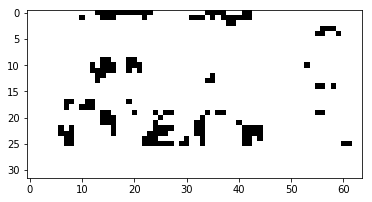

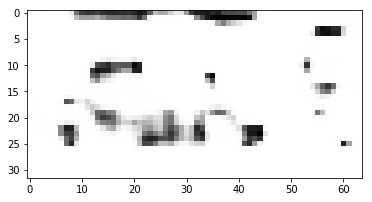

images/241.jpg


In [39]:
# Let's just view a few input images and output images from the autoencoder
#   This includes the decoder part of the autoencoder, so we'll still see an image

next_batch, next_filenames = next(test_images) # Use the test_images defined above
#next_batch = next(test_generator)
images = next_batch[0]
first_image=images[0]
second_image=images[1]

plt.imshow(get_image(first_image))
plt.show()

#plt.imshow(second_image)
#plt.show()

recreated_pill = autoencoder.predict(x=images,batch_size=32)

plt.imshow(get_image(recreated_pill[0]))
plt.show()
print(next_filenames[0])



# Get a feel for the outputs

In [40]:
# Load a dataframe from the dictionary
import pandas as pd
df = pd.DataFrame.from_dict(image_encoding_dict, orient='index')

#df['filename'] = df.index
#df['image']= df['filename'].apply(lambda x: x.split('/')[-1])
#HOLY COW!  All of these are so close together. :-(  Can't differentiate one from another easily - Deeper network help?
#df.to_csv('96_images_32x64_AvgPool_4x8.csv')

df

,0,1,2,3,4,5,6,7,8,9,...,118,119,120,121,122,123,124,125,126,127
images/229.jpg,0.161406,0.596749,0.342285,0.093929,0.659525,0.242705,0.256929,0.383674,0.872080,0.076821,...,0.380705,0.687636,0.556766,0.514994,0.477748,0.363931,0.280854,0.193367,0.924065,0.598757
images/229_196.jpg,0.141045,0.601013,0.311303,0.098178,0.713818,0.266619,0.224479,0.354696,1.068582,0.077986,...,0.365910,0.912011,0.567931,0.596736,0.477612,0.401822,0.321534,0.241801,0.927817,0.668052
images/229_262.jpg,0.144027,0.523242,0.296691,0.108407,0.701285,0.307031,0.258711,0.374923,0.914382,0.057388,...,0.432438,0.852726,0.670040,0.524443,0.529170,0.358740,0.259329,0.222265,1.014982,0.644159
images/229_45.jpg,0.156573,0.634740,0.316035,0.114641,0.647836,0.268413,0.180888,0.289561,1.013298,0.082357,...,0.299450,0.705809,0.556756,0.507814,0.430249,0.376070,0.278531,0.230805,0.949390,0.587902
images/230.jpg,0.297795,0.436089,0.334377,0.190056,0.549574,0.194418,0.211451,0.247689,0.700121,0.116547,...,0.247673,0.366851,0.620995,0.599455,0.533699,0.447776,0.371017,0.201324,0.522469,0.521846
images/230_200.jpg,0.248182,0.395954,0.377633,0.169309,0.567359,0.201230,0.278193,0.232585,0.602054,0.143889,...,0.256849,0.368649,0.598940,0.540380,0.551595,0.446557,0.365912,0.210914,0.690711,0.623310
images/230_287.jpg,0.177851,0.397143,0.356402,0.175322,0.543327,0.189020,0.316937,0.234121,0.661916,0.073690,...,0.286587,0.438843,0.584003,0.444537,0.461145,0.474523,0.381318,0.172563,0.656867,0.542671
images/230_341.jpg,0.226257,0.355987,0.352969,0.224996,0.563489,0.185164,0.249669,0.272671,0.636761,0.142379,...,0.208105,0.342491,0.490331,0.481664,0.441018,0.473007,0.332762,0.188852,0.564211,0.489326
images/231.jpg,0.245036,0.444580,0.431144,0.190621,0.618081,0.201996,0.332405,0.281684,0.768200,0.091313,...,0.334510,0.397567,0.608128,0.367854,0.617812,0.468394,0.329689,0.216373,0.651934,0.570153
images/231_212.jpg,0.255415,0.523068,0.439342,0.175935,0.576077,0.219129,0.361404,0.240991,0.809728,0.099029,...,0.320487,0.408581,0.592684,0.466357,0.550116,0.490854,0.288900,0.186744,0.729688,0.578595


In [41]:
# Look at the simple statistics around the encodings
dfstat = df.describe()
dfstat

,0,1,2,3,4,5,6,7,8,9,...,118,119,120,121,122,123,124,125,126,127
count,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,...,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000
mean,0.218422,0.478239,0.359643,0.146161,0.612516,0.233328,0.294621,0.292344,0.772874,0.110318,...,0.310300,0.520624,0.558393,0.520348,0.488709,0.422463,0.327599,0.190042,0.723091,0.577925
std,0.063443,0.086286,0.054641,0.045608,0.068936,0.077063,0.057795,0.069201,0.108401,0.045046,...,0.094668,0.153835,0.057904,0.077152,0.068683,0.052415,0.046004,0.056792,0.156218,0.110138
min,0.094550,0.255145,0.225629,0.058666,0.391780,0.055148,0.180876,0.099156,0.435287,0.033637,...,0.059987,0.148775,0.435676,0.340806,0.357107,0.324543,0.195188,0.038063,0.339911,0.342935
25%,0.174111,0.436556,0.316942,0.114751,0.576109,0.188546,0.251041,0.258248,0.707941,0.077010,...,0.258063,0.408471,0.515257,0.466304,0.442854,0.378833,0.299681,0.158854,0.646158,0.507707
50%,0.222029,0.475810,0.355317,0.136351,0.614110,0.228628,0.297964,0.289478,0.778653,0.109099,...,0.316429,0.532792,0.560377,0.512948,0.480889,0.414799,0.323028,0.201948,0.734708,0.552537
75%,0.255428,0.531772,0.405974,0.175467,0.657378,0.282374,0.341442,0.331942,0.845446,0.138260,...,0.378752,0.618528,0.596502,0.568973,0.529357,0.471992,0.362202,0.231955,0.837738,0.638876
max,0.385677,0.762578,0.504894,0.270693,0.793210,0.415076,0.419999,0.436706,1.068582,0.267392,...,0.513435,0.912011,0.720365,0.694227,0.687412,0.542925,0.420365,0.290240,1.119105,0.954865


In [42]:
# See how they all cluster
from sklearn.cluster import KMeans

number_of_clusters=24
km = KMeans(n_clusters=number_of_clusters)
# Normally people fit the matrix
km.fit(df)
print(km.labels_)

[ 8  8  8  8 12 10 10 12 10 10 10 10 18 10 18 18 12 12 12 12  6  6  6  6
 11 11 11 11 15 15 15 15 17  9 17 17  1  1  1  1 20 20 20 20  2  2  2  2
  3 22  3  3  5  5  5  5  0  0  0  0  9  9  9  9 23  7 23 23 16 16 13 13
  1  2 12 12  8 16  8 11 19 19 19 19 21 21 10 21  4  4  4  4 14 14 14 14]


In [43]:
# Convert results to a dataframe - note that to get the index / filename, I had to include the first column
results = pd.DataFrame({
    'ignore': df[0],
    'category': km.labels_
})
results

,ignore,category
images/229.jpg,0.161406,8
images/229_196.jpg,0.141045,8
images/229_262.jpg,0.144027,8
images/229_45.jpg,0.156573,8
images/230.jpg,0.297795,12
images/230_200.jpg,0.248182,10
images/230_287.jpg,0.177851,10
images/230_341.jpg,0.226257,12
images/231.jpg,0.245036,10
images/231_212.jpg,0.255415,10


In [44]:
#show the distance between images
#  should be small distances between rotated images - ideally zero
from scipy.spatial.distance import squareform, pdist
distdf = pd.DataFrame(squareform(pdist(df.iloc[:, 1:])), columns = df.index.unique(), index=df.index.unique()) #, columns=df['image'].unique(), index=df['image'].unique())
distdf

,images/229.jpg,images/229_196.jpg,images/229_262.jpg,images/229_45.jpg,images/230.jpg,images/230_200.jpg,images/230_287.jpg,images/230_341.jpg,images/231.jpg,images/231_212.jpg,...,images/250_323.jpg,images/250_331.jpg,images/251.jpg,images/251_327.jpg,images/251_355.jpg,images/251_48.jpg,images/252.jpg,images/252_135.jpg,images/252_68.jpg,images/252_75.jpg
images/229.jpg,0.000000,0.809756,0.735286,0.559763,1.873715,1.853582,1.644313,2.156613,1.643081,1.528510,...,1.542007,1.264104,3.086596,3.274568,3.433921,3.178045,1.398104,1.483236,1.521989,1.347414
images/229_196.jpg,0.809756,0.000000,0.661119,0.716121,2.353113,2.349669,2.136735,2.626811,2.120354,2.028763,...,2.061014,1.697103,3.505401,3.706424,3.876952,3.625379,1.735806,1.877718,1.906928,1.700782
images/229_262.jpg,0.735286,0.661119,0.000000,0.822140,2.240058,2.221860,1.998973,2.526750,2.033335,1.896845,...,1.937442,1.588993,3.458558,3.646444,3.808908,3.541709,1.627529,1.767867,1.871875,1.625363
images/229_45.jpg,0.559763,0.716121,0.822140,0.000000,2.000102,2.007568,1.770470,2.287255,1.802208,1.692723,...,1.713588,1.410211,3.209708,3.392707,3.569978,3.311927,1.492118,1.601378,1.615239,1.448212
images/230.jpg,1.873715,2.353113,2.240058,2.000102,0.000000,0.549856,0.607698,0.593743,0.779251,0.918331,...,0.860423,1.275227,1.528006,1.668118,1.813029,1.522101,1.271744,1.125781,1.074473,1.128537
images/230_200.jpg,1.853582,2.349669,2.221860,2.007568,0.549856,0.000000,0.574760,0.734542,0.730353,0.814550,...,0.789739,1.212344,1.600780,1.763868,1.899872,1.625633,1.272265,1.052210,1.098956,1.098922
images/230_287.jpg,1.644313,2.136735,1.998973,1.770470,0.607698,0.574760,0.000000,0.833940,0.726776,0.727960,...,0.725734,1.033877,1.786891,1.930466,2.092095,1.814795,1.173015,1.011660,1.008322,1.021034
images/230_341.jpg,2.156613,2.626811,2.526750,2.287255,0.593743,0.734542,0.833940,0.000000,1.037223,1.201649,...,1.107826,1.578303,1.219379,1.283232,1.442710,1.179370,1.402741,1.255428,1.126746,1.295608
images/231.jpg,1.643081,2.120354,2.033335,1.802208,0.779251,0.730353,0.726776,1.037223,0.000000,0.656813,...,0.742853,0.994575,1.776667,1.987270,2.122644,1.853387,1.251946,1.034311,1.097078,1.084597
images/231_212.jpg,1.528510,2.028763,1.896845,1.692723,0.918331,0.814550,0.727960,1.201649,0.656813,0.000000,...,0.670216,0.885909,2.043420,2.239294,2.370948,2.091531,1.209722,0.982413,1.141945,1.005547


In [45]:
# Show the covariance between the columns - not useful since it's unscaled. :-(
#covdf = df.cov()*10000 #, columns = df.index.unique(), index=df.index.unique()) #, columns=df['image'].unique(), index=df['image'].unique())
#covdf

In [46]:
# Show the correlation between the columns (which represent a global pool from the encoder convolutions)
#   Correlation appears high, likely could do some PCA, but seems like tuning the autoencoder should be able to do that
corrdf = df.corr() #, columns = df.index.unique(), index=df.index.unique()) #, columns=df['image'].unique(), index=df['image'].unique())
corrdf

,0,1,2,3,4,5,6,7,8,9,...,118,119,120,121,122,123,124,125,126,127
0,1.000000,-0.661490,0.504734,0.645417,-0.494644,-0.624569,-0.149820,-0.603940,-0.511987,0.573959,...,-0.501294,-0.722339,-0.123255,0.056172,0.327101,0.544909,0.451090,0.479605,-0.640970,-0.564360
1,-0.661490,1.000000,-0.358064,-0.727305,0.502903,0.634407,0.023302,0.709133,0.604395,-0.674483,...,0.593983,0.751621,0.116440,0.173662,-0.320088,-0.516527,-0.645215,-0.317033,0.796752,0.535629
2,0.504734,-0.358064,1.000000,0.440214,-0.413190,-0.563625,0.226969,-0.508458,-0.269627,0.215033,...,-0.479269,-0.635838,0.080656,0.052253,0.420220,0.619774,0.366113,0.399365,-0.486375,-0.411226
3,0.645417,-0.727305,0.440214,1.000000,-0.650592,-0.622129,0.002544,-0.715383,-0.631315,0.601897,...,-0.614927,-0.815560,-0.223588,-0.282772,0.253179,0.677902,0.515732,0.296267,-0.798285,-0.604857
4,-0.494644,0.502903,-0.413190,-0.650592,1.000000,0.498702,-0.018622,0.650549,0.743153,-0.494937,...,0.727541,0.760936,0.286602,0.285215,-0.209281,-0.653276,-0.512351,-0.224010,0.692955,0.438119
5,-0.624569,0.634407,-0.563625,-0.622129,0.498702,1.000000,0.304931,0.664116,0.422346,-0.463687,...,0.603022,0.665464,0.255969,-0.020856,-0.147257,-0.506594,-0.523822,-0.556139,0.633958,0.689503
6,-0.149820,0.023302,0.226969,0.002544,-0.018622,0.304931,1.000000,0.074721,0.011803,-0.203655,...,0.019159,-0.144652,0.269168,-0.044650,0.175603,0.162800,-0.063334,-0.190814,-0.077452,0.159157
7,-0.603940,0.709133,-0.508458,-0.715383,0.650549,0.664116,0.074721,1.000000,0.579443,-0.576287,...,0.700675,0.780669,0.180089,0.265823,-0.281518,-0.597336,-0.497978,-0.327274,0.745683,0.454199
8,-0.511987,0.604395,-0.269627,-0.631315,0.743153,0.422346,0.011803,0.579443,1.000000,-0.586795,...,0.625019,0.739140,0.243424,0.224950,-0.233745,-0.589846,-0.538369,-0.238757,0.705500,0.409724
9,0.573959,-0.674483,0.215033,0.601897,-0.494937,-0.463687,-0.203655,-0.576287,-0.586795,1.000000,...,-0.554399,-0.600741,-0.312199,-0.182134,0.160291,0.454007,0.669429,0.289546,-0.686505,-0.474537


# Annoy for nearest neighbor search

In [47]:
# Create Annoy database file

from annoy import AnnoyIndex

embedding_vector_size = 128

f = embedding_vector_size      # Length of item vector that will be indexed
t = AnnoyIndex(f)  

for i in range(len(image_encoding_dict)):
    t.add_item(i,image_encoding_dict[image_filename_dict[i]])
    
t.build(25) # 25 trees - need to explore what is a good setting here
t.save(model_name + '.ann') # Save the model



True

In [48]:
# Open Annoy database file get example

sample_item_index = 0
nn_count = 6 # count of nearest neighbors to find

u = AnnoyIndex(f)
u.load(model_name + '.ann') # super fast, will just mmap the file

nn = u.get_nns_by_item(sample_item_index, nn_count) # will find the 5 nearest neighbors

for i in nn:
    distance = u.get_distance(sample_item_index, i)
    print(str(i) + ' - ' + image_filename_dict[i] + ' : ' + str(distance))
    



0 - images/229.jpg : 0.0
3 - images/229_45.jpg : 0.09634862095117569
76 - images/248.jpg : 0.12293408811092377
79 - images/248_7.jpg : 0.12380210310220718
2 - images/229_262.jpg : 0.12508824467658997
78 - images/248_175.jpg : 0.12682965397834778


In [102]:
# Calculate some metric of goodness. Basically, see how many pills clump when rotated. 
#   In other words, the 4 closest pills to pill 219 should be itself plus the three rotations of it.

number_rotations = 4 # the total images for each pill
same_images={key: [key,key+1,key+2,key+3] for key in image_filename_dict if key % 4 == 0}
same_images # key is first value, value is list with all the similar images

incorrect_pills = 0 #sum of count of pills
incorrect_pill_images = 0 # sum of ALL the mistakes

total_pills = len(image_filename_dict)/number_rotations
total_pill_images = len(image_filename_dict)

for key, value in same_images.items():
    top4 = u.get_nns_by_item(key, 4)
    mismatches = set(value)-set(top4)
    if len(mismatches) != 0:
        incorrect_pills += 1
        incorrect_pill_images += len(mismatches)
        
    pass

print(f'Number of incorrect pills:       {incorrect_pills} out of {total_pills} pills')
print(f"Number of incorrect pill images: {incorrect_pill_images} out of {total_pill_images} images")


Number of incorrect pills:       14 out of 24.0 pills
Number of incorrect pill images: 17 out of 96 images


In [88]:
##### top4 = u.get_nns_by_item(0, 4)
print(top4)
for s in [0,1,2,3]:
    if s in top4:
        print("yes")

a = [0,1,2,3]
z = set(a)-set(top4)
z

[0, 3, 76, 79]
yes
yes


{1, 2}

In [49]:
# For confusion matrix, you need two items, y_test and y_pred
#     y_test is the known categorical values of the test set 
#     y_pred is the predicted categorical values of the test set 

# To get y_test we'll use the validation_generator, but let's grab all images
#test_generator.batch_size = 751

nb_batches_to_capture = 1 # batches * batch_size should be less than total number of items available, else repeats will happen

y_true = []
y_pred = []

for index in range(nb_batches_to_capture):
    next_batch = next(test_generator)
    #images = next_batch[0]
    #print(images[0])
    categories = next_batch[1]
    #print(categories[0])
    #print(len(categories))
    # To get y_pred, we actually need to predict the categories of the all_images set
    #predicted_categories= model.predict_classes(x=images,batch_size=batch_size)
    #print(len(predicted_categories))
    #if len(categories) == len(predicted_categories):
    #    y_true.extend(categories)
    #    y_pred.extend(predicted_categories)
    #else:
    #    print("Mismatched actual and predicted - ignoring batch")
    
print(len(y_true))
print(len(y_pred))

NameError: name 'test_generator' is not defined

In [191]:
# Create methods for determining closest image
def retrieve_closest_elements(test_code, test_label, learned_codes):
    distances = []
    for code in learned_codes:
        distance = np.linalg.norm(code - test_code)
        distances.append(distance)
    nb_elements = learned_codes.shape[0]
    distances = np.array(distances)
    learned_code_index = np.arange(nb_elements)
    labels = np.copy(y_train).astype('float32')
    labels[labels != test_label] = -1
    labels[labels == test_label] = 1
    labels[labels == -1] = 0
    distance_with_labels = np.stack((distances, labels, learned_code_index), axis=-1)
    sorted_distance_with_labels = distance_with_labels[distance_with_labels[:, 0].argsort()]

    sorted_distances = 28 - sorted_distance_with_labels[:, 0]
    sorted_labels = sorted_distance_with_labels[:, 1]
    sorted_indexes = sorted_distance_with_labels[:, 2]
    return sorted_distances, sorted_labels, sorted_indexes


def compute_average_precision_score(test_codes, test_labels, learned_codes, n_samples):
    out_labels = []
    out_distances = []
    retrieved_elements_indexes = []
    for i in range(len(test_codes)):
        sorted_distances, sorted_labels, sorted_indexes = retrieve_closest_elements(test_codes[i], test_labels[i], learned_codes)
        out_distances.append(sorted_distances[:n_samples])
        out_labels.append(sorted_labels[:n_samples])
        retrieved_elements_indexes.append(sorted_indexes[:n_samples])

    out_labels = np.array(out_labels)
    out_labels_file_name = 'computed_data/out_labels_{}'.format(n_samples)
    np.save(out_labels_file_name, out_labels)

    out_distances_file_name = 'computed_data/out_distances_{}'.format(n_samples)
    out_distances = np.array(out_distances)
    np.save(out_distances_file_name, out_distances)
    score = label_ranking_average_precision_score(out_labels, out_distances)
    scores.append(score)
    return score


def retrieve_closest_images(test_element, test_label, n_samples=10):
    learned_codes = encoder.predict(x_train)
    learned_codes = learned_codes.reshape(learned_codes.shape[0],
                                          learned_codes.shape[1] * learned_codes.shape[2] * learned_codes.shape[3])

    test_code = encoder.predict(np.array([test_element]))
    test_code = test_code.reshape(test_code.shape[1] * test_code.shape[2] * test_code.shape[3])

    distances = []

    for code in learned_codes:
        distance = np.linalg.norm(code - test_code)
        distances.append(distance)
    nb_elements = learned_codes.shape[0]
    distances = np.array(distances)
    learned_code_index = np.arange(nb_elements)
    labels = np.copy(y_train).astype('float32')
    labels[labels != test_label] = -1
    labels[labels == test_label] = 1
    labels[labels == -1] = 0
    distance_with_labels = np.stack((distances, labels, learned_code_index), axis=-1)
    sorted_distance_with_labels = distance_with_labels[distance_with_labels[:, 0].argsort()]

    sorted_distances = 28 - sorted_distance_with_labels[:, 0]
    sorted_labels = sorted_distance_with_labels[:, 1]
    sorted_indexes = sorted_distance_with_labels[:, 2]
    kept_indexes = sorted_indexes[:n_samples]

    score = label_ranking_average_precision_score(np.array([sorted_labels[:n_samples]]), np.array([sorted_distances[:n_samples]]))

    print("Average precision ranking score for tested element is {}".format(score))

    original_image = x_test[0]
    cv2.imshow('original_image', original_image)
    retrieved_images = x_train[int(kept_indexes[0]), :]
    for i in range(1, n_samples):
        retrieved_images = np.hstack((retrieved_images, x_train[int(kept_indexes[i]), :]))
    cv2.imshow('Results', retrieved_images)
    #cv2.waitKey(0)

    cv2.imwrite('test_results/original_image.jpg', 255 * cv2.resize(original_image, (0,0), fx=3, fy=3))
    cv2.imwrite('test_results/retrieved_results.jpg', 255 * cv2.resize(retrieved_images, (0,0), fx=2, fy=2))



In [192]:
# Create methods to test the model
def test_model(n_test_samples, n_train_samples):
    learned_codes = encoder.predict(x_train)
    learned_codes = learned_codes.reshape(learned_codes.shape[0], learned_codes.shape[1] * learned_codes.shape[2] * learned_codes.shape[3])
    test_codes = encoder.predict(x_test)
    test_codes = test_codes.reshape(test_codes.shape[0], test_codes.shape[1] * test_codes.shape[2] * test_codes.shape[3])
    indexes = np.arange(len(y_test))
    np.random.shuffle(indexes)
    indexes = indexes[:n_test_samples]

    print('Start computing score for {} train samples'.format(n_train_samples))
    t1 = time.time()
    score = compute_average_precision_score(test_codes[indexes], y_test[indexes], learned_codes, n_train_samples)
    t2 = time.time()
    print('Score computed in: ', t2-t1)
    print('Model score:', score)


def plot_denoised_images():
    denoised_images = autoencoder.predict(x_test_noisy.reshape(x_test_noisy.shape[0], x_test_noisy.shape[1], x_test_noisy.shape[2], 1))
    test_img = x_test_noisy[0]
    resized_test_img = cv2.resize(test_img, (280, 280))
    #cv2.imshow('input', resized_test_img)
    #cv2.waitKey(0)
    output = denoised_images[0]
    resized_output = cv2.resize(output, (280, 280))
    #cv2.imshow('output', resized_output)
    #cv2.waitKey(0)
    cv2.imwrite('test_results/noisy_image.jpg', 255 * resized_test_img)
    cv2.imwrite('test_results/denoised_image.jpg', 255 * resized_output)


In [ ]:
# Save model
np.save('computed_data/scores', np.array(scores))

In [ ]:
# To retrieve closest image
retrieve_closest_images(x_test[0], y_test[0])


In [ ]:

# To plot a denoised image
plot_denoised_images()

In [ ]:
print('hello')